<a href="https://colab.research.google.com/github/Lucidousme/Transportation-Analysis/blob/main/Lagos_deliveries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import (
    precision_recall_curve, classification_report, roc_auc_score,
    confusion_matrix, fbeta_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import shap
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


#Load Datasets

In [4]:
lagos_delivery = pd.read_csv("lagos_deliveries_raw.csv")
print(lagos_delivery.head())

  delivery_id  order_date delivery_date pickup_location pickup_zone  \
0    DEL00001  11/21/2024    11/21/2024           Ikeja    Mainland   
1    DEL00002  11/15/2024    11/18/2024           Ikeja    Mainland   
2    DEL00003   11/9/2024    11/12/2024            Ajah      Island   
3    DEL00004   9/20/2024     9/21/2024          Mushin    Mainland   
4    DEL00005   11/8/2024     11/8/2024             Epe    Mainland   

  delivery_location delivery_zone  distance_km  delivery_time_minutes  \
0             Apapa      Mainland         9.13                   46.0   
1            Ikeja       Mainland         6.41                   27.0   
2          Maryland      Mainland        29.73                  121.0   
3              Yaba      Mainland         6.53                   26.0   
4             Ikoyi        Island        16.97                   59.0   

              time_slot day_of_week delivery_status  delivery_cost_ngn  \
0      Morning (7-11am)    Thursday          Failed         

In [5]:
print(lagos_delivery.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   delivery_id            913 non-null    object 
 1   order_date             913 non-null    object 
 2   delivery_date          913 non-null    object 
 3   pickup_location        913 non-null    object 
 4   pickup_zone            913 non-null    object 
 5   delivery_location      913 non-null    object 
 6   delivery_zone          913 non-null    object 
 7   distance_km            913 non-null    float64
 8   delivery_time_minutes  895 non-null    float64
 9   time_slot              913 non-null    object 
 10  day_of_week            913 non-null    object 
 11  delivery_status        913 non-null    object 
 12  delivery_cost_ngn      913 non-null    float64
 13  package_weight_kg      886 non-null    float64
 14  customer_rating        705 non-null    float64
 15  traffi

#Data Preprocessing and Cleaning

This sections contains the preprocessing and cleaning process. The dataset has certain inconsistencies like missing data, and certain observation were recorded in uppercase while others in lowercase. Therefore, I checked and changed all these inconsistencies to ensure the dataset is ready for further analysis.


Fix Data Types

Some data types were entered in the wrong format, so I started by changing them to the correct format as this can affect further analysis if left like that.

In [6]:
#Change order_date and delivery date to appropriate data type

lagos_delivery['order_date'] = pd.to_datetime(lagos_delivery['order_date'], errors = 'coerce', dayfirst=True)
lagos_delivery['delivery_date'] = pd.to_datetime(lagos_delivery['delivery_date'], errors = 'coerce', dayfirst=True)
print(lagos_delivery.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   delivery_id            913 non-null    object        
 1   order_date             832 non-null    datetime64[ns]
 2   delivery_date          913 non-null    datetime64[ns]
 3   pickup_location        913 non-null    object        
 4   pickup_zone            913 non-null    object        
 5   delivery_location      913 non-null    object        
 6   delivery_zone          913 non-null    object        
 7   distance_km            913 non-null    float64       
 8   delivery_time_minutes  895 non-null    float64       
 9   time_slot              913 non-null    object        
 10  day_of_week            913 non-null    object        
 11  delivery_status        913 non-null    object        
 12  delivery_cost_ngn      913 non-null    float64       
 13  packa

Date fields were converted from object to datetime to enable correct temporal ordering, duration calculations, and validation checks.

Standardizing Categorical Values

There are incosistent values in some columns. So, I standardized the values in the column.

In [7]:
#change inconsistent delivery status
lagos_delivery['delivery_status'] = lagos_delivery['delivery_status'].str.title().str.strip()
lagos_delivery['delivery_status'] = lagos_delivery['delivery_status'].replace({'Ret':'Returned'})
lagos_delivery['delivery_status'] = lagos_delivery['delivery_status'].replace({'Del':'Delivered'})
print(lagos_delivery.head())

  delivery_id order_date delivery_date pickup_location pickup_zone  \
0    DEL00001 2024-11-21    2024-11-21           Ikeja    Mainland   
1    DEL00002 2024-11-15    2024-11-18           Ikeja    Mainland   
2    DEL00003 2024-11-09    2024-11-12            Ajah      Island   
3    DEL00004 2024-09-20    2024-09-21          Mushin    Mainland   
4    DEL00005 2024-11-08    2024-11-08             Epe    Mainland   

  delivery_location delivery_zone  distance_km  delivery_time_minutes  \
0             Apapa      Mainland         9.13                   46.0   
1            Ikeja       Mainland         6.41                   27.0   
2          Maryland      Mainland        29.73                  121.0   
3              Yaba      Mainland         6.53                   26.0   
4             Ikoyi        Island        16.97                   59.0   

              time_slot day_of_week delivery_status  delivery_cost_ngn  \
0      Morning (7-11am)    Thursday          Failed            226

In [8]:
#Standardized the pickup_location and delivery_location
lagos_delivery['pickup_location'] = lagos_delivery['pickup_location'].str.title().str.strip()
lagos_delivery['delivery_location'] = lagos_delivery['delivery_location'].str.title().str.strip()
print(lagos_delivery.head())

  delivery_id order_date delivery_date pickup_location pickup_zone  \
0    DEL00001 2024-11-21    2024-11-21           Ikeja    Mainland   
1    DEL00002 2024-11-15    2024-11-18           Ikeja    Mainland   
2    DEL00003 2024-11-09    2024-11-12            Ajah      Island   
3    DEL00004 2024-09-20    2024-09-21          Mushin    Mainland   
4    DEL00005 2024-11-08    2024-11-08             Epe    Mainland   

  delivery_location delivery_zone  distance_km  delivery_time_minutes  \
0             Apapa      Mainland         9.13                   46.0   
1             Ikeja      Mainland         6.41                   27.0   
2          Maryland      Mainland        29.73                  121.0   
3              Yaba      Mainland         6.53                   26.0   
4             Ikoyi        Island        16.97                   59.0   

              time_slot day_of_week delivery_status  delivery_cost_ngn  \
0      Morning (7-11am)    Thursday          Failed            226

Checking and Handling Missing Values

In this section, I checked and handled missing values in the dataset. This is to ensure data quality and also prepare for further analysis.

In [9]:
print(lagos_delivery.isnull().sum())

delivery_id                0
order_date                81
delivery_date              0
pickup_location            0
pickup_zone                0
delivery_location          0
delivery_zone              0
distance_km                0
delivery_time_minutes     18
time_slot                  0
day_of_week                0
delivery_status            0
delivery_cost_ngn          0
package_weight_kg         27
customer_rating          208
traffic_level              0
dtype: int64


In [10]:
#Handle missing data in the Package weight column
median_weight = lagos_delivery['package_weight_kg'].median()
lagos_delivery['package_weight_kg'] = lagos_delivery['package_weight_kg'].fillna(median_weight)

# Handle missing data in 'customer_rating' by filling with the median
median_customer_rating = lagos_delivery['customer_rating'].median()
lagos_delivery['customer_rating'] = lagos_delivery['customer_rating'].fillna(median_customer_rating)

#Handle missing data in the Delivery time column
median_time = lagos_delivery['delivery_time_minutes'].median()
lagos_delivery['delivery_time_minutes'] = lagos_delivery['delivery_time_minutes'].fillna(median_time)
print(lagos_delivery.isnull().sum())

delivery_id               0
order_date               81
delivery_date             0
pickup_location           0
pickup_zone               0
delivery_location         0
delivery_zone             0
distance_km               0
delivery_time_minutes     0
time_slot                 0
day_of_week               0
delivery_status           0
delivery_cost_ngn         0
package_weight_kg         0
customer_rating           0
traffic_level             0
dtype: int64


After filling missing values in the package weight, customer rating, and delivery time. There were missing values in the order date. The missing values are 81 and that is more than 5% of the entire column so these missing values cannot be dropped.

In [11]:
#Handle the missing values in the order date column using the delivery_time_minutes
missing_mask = lagos_delivery['order_date'].isnull()

lagos_delivery.loc[missing_mask, 'order_date'] = (
    pd.to_datetime(lagos_delivery.loc[missing_mask, 'delivery_date']) -
    pd.to_timedelta(lagos_delivery.loc[missing_mask, 'delivery_time_minutes'], unit='m')
)

print(f"Missing order dates after filling: {lagos_delivery['order_date'].isnull().sum()}")

Missing order dates after filling: 0


In [12]:
# Handle values with 0 in the distance_km column
print(f"Rows with 0 km: {(lagos_delivery['distance_km'] == 0).sum()}")

# Drop if acceptable
lagos_delivery = lagos_delivery[lagos_delivery['distance_km'] > 0]

print(f"Remaining rows: {len(lagos_delivery)}")

Rows with 0 km: 4
Remaining rows: 909


In [13]:
print(lagos_delivery.isnull().sum())

delivery_id              0
order_date               0
delivery_date            0
pickup_location          0
pickup_zone              0
delivery_location        0
delivery_zone            0
distance_km              0
delivery_time_minutes    0
time_slot                0
day_of_week              0
delivery_status          0
delivery_cost_ngn        0
package_weight_kg        0
customer_rating          0
traffic_level            0
dtype: int64


In [14]:
print(lagos_delivery.head(20))

   delivery_id          order_date delivery_date  pickup_location pickup_zone  \
0     DEL00001 2024-11-21 00:00:00    2024-11-21            Ikeja    Mainland   
1     DEL00002 2024-11-15 00:00:00    2024-11-18            Ikeja    Mainland   
2     DEL00003 2024-11-09 00:00:00    2024-11-12             Ajah      Island   
3     DEL00004 2024-09-20 00:00:00    2024-09-21           Mushin    Mainland   
4     DEL00005 2024-11-08 00:00:00    2024-11-08              Epe    Mainland   
5     DEL00006 2024-09-09 00:00:00    2024-09-09          Gbagada    Mainland   
6     DEL00007 2024-09-21 00:00:00    2024-09-23             Yaba    Mainland   
7     DEL00008 2024-10-02 00:00:00    2024-10-03         Maryland    Mainland   
8     DEL00009 2024-09-30 00:00:00    2024-09-30           Mushin    Mainland   
9     DEL00010 2024-11-22 00:00:00    2024-11-25            Lekki      Island   
10    DEL00011 2024-10-17 00:00:00    2024-10-18            Lekki      Island   
11    DEL00012 2024-09-09 00

Feature Engineering

In [15]:
lagos_delivery['is_weekend'] = lagos_delivery['day_of_week'].isin(['Saturday','Sunday']).astype(int)
lagos_delivery['cost_per_km'] = lagos_delivery['delivery_cost_ngn'] / lagos_delivery['distance_km']
print(lagos_delivery.head())

  delivery_id order_date delivery_date pickup_location pickup_zone  \
0    DEL00001 2024-11-21    2024-11-21           Ikeja    Mainland   
1    DEL00002 2024-11-15    2024-11-18           Ikeja    Mainland   
2    DEL00003 2024-11-09    2024-11-12            Ajah      Island   
3    DEL00004 2024-09-20    2024-09-21          Mushin    Mainland   
4    DEL00005 2024-11-08    2024-11-08             Epe    Mainland   

  delivery_location delivery_zone  distance_km  delivery_time_minutes  \
0             Apapa      Mainland         9.13                   46.0   
1             Ikeja      Mainland         6.41                   27.0   
2          Maryland      Mainland        29.73                  121.0   
3              Yaba      Mainland         6.53                   26.0   
4             Ikoyi        Island        16.97                   59.0   

              time_slot day_of_week delivery_status  delivery_cost_ngn  \
0      Morning (7-11am)    Thursday          Failed            226

In [16]:
lagos_delivery['is_morning'] = lagos_delivery['time_slot'].str.contains('Morning', na=False).astype(int)
lagos_delivery['is_evening'] = lagos_delivery['time_slot'].str.contains('Evening', na=False).astype(int)
print(lagos_delivery.head())

  delivery_id order_date delivery_date pickup_location pickup_zone  \
0    DEL00001 2024-11-21    2024-11-21           Ikeja    Mainland   
1    DEL00002 2024-11-15    2024-11-18           Ikeja    Mainland   
2    DEL00003 2024-11-09    2024-11-12            Ajah      Island   
3    DEL00004 2024-09-20    2024-09-21          Mushin    Mainland   
4    DEL00005 2024-11-08    2024-11-08             Epe    Mainland   

  delivery_location delivery_zone  distance_km  delivery_time_minutes  \
0             Apapa      Mainland         9.13                   46.0   
1             Ikeja      Mainland         6.41                   27.0   
2          Maryland      Mainland        29.73                  121.0   
3              Yaba      Mainland         6.53                   26.0   
4             Ikoyi        Island        16.97                   59.0   

              time_slot day_of_week delivery_status  delivery_cost_ngn  \
0      Morning (7-11am)    Thursday          Failed            226

#Full Analysis

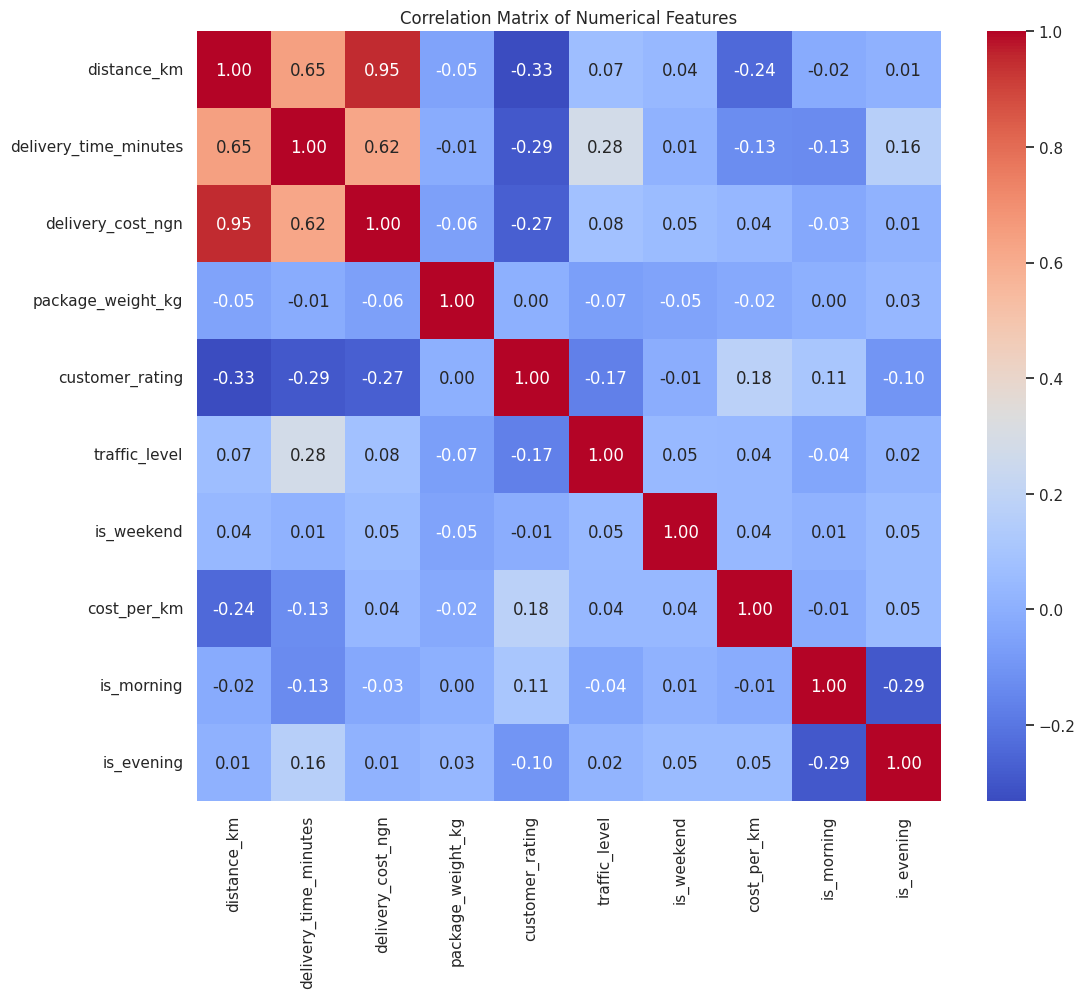

Correlation Matrix:
                       distance_km  delivery_time_minutes  delivery_cost_ngn  \
distance_km               1.000000               0.645300           0.952201   
delivery_time_minutes     0.645300               1.000000           0.621281   
delivery_cost_ngn         0.952201               0.621281           1.000000   
package_weight_kg        -0.051303              -0.013458          -0.058437   
customer_rating          -0.332632              -0.292605          -0.272473   
traffic_level             0.067995               0.279350           0.079645   
is_weekend                0.036979               0.011353           0.052807   
cost_per_km              -0.239265              -0.125875           0.036800   
is_morning               -0.015591              -0.132851          -0.028012   
is_evening                0.007573               0.162942           0.013802   

                       package_weight_kg  customer_rating  traffic_level  \
distance_km            

In [17]:
numerical_cols = lagos_delivery.select_dtypes(include=np.number).columns
correlation_matrix = lagos_delivery[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

#What are the key drivers of delivery failure, and how can we reduce them?

In [18]:
#create a failure flag
lagos_delivery['failed_delivery'] = (lagos_delivery['delivery_status'] =='Failed').astype(int)
print(lagos_delivery)

      delivery_id          order_date delivery_date pickup_location  \
0        DEL00001 2024-11-21 00:00:00    2024-11-21           Ikeja   
1        DEL00002 2024-11-15 00:00:00    2024-11-18           Ikeja   
2        DEL00003 2024-11-09 00:00:00    2024-11-12            Ajah   
3        DEL00004 2024-09-20 00:00:00    2024-09-21          Mushin   
4        DEL00005 2024-11-08 00:00:00    2024-11-08             Epe   
..            ...                 ...           ...             ...   
908  DEL00951_DUP 2024-11-25 22:48:00    2024-11-26             Epe   
909  DEL00425_DUP 2024-11-10 00:00:00    2024-11-11            Ajah   
910  DEL00421_DUP 2024-09-06 00:00:00    2024-09-06          Mushin   
911  DEL00530_DUP 2024-09-21 00:00:00    2024-09-21          Festac   
912  DEL00514_DUP 2024-10-09 00:00:00    2024-10-09          Mushin   

    pickup_zone delivery_location delivery_zone  distance_km  \
0      Mainland             Apapa      Mainland         9.13   
1      Mainland    

Univariate Analysis

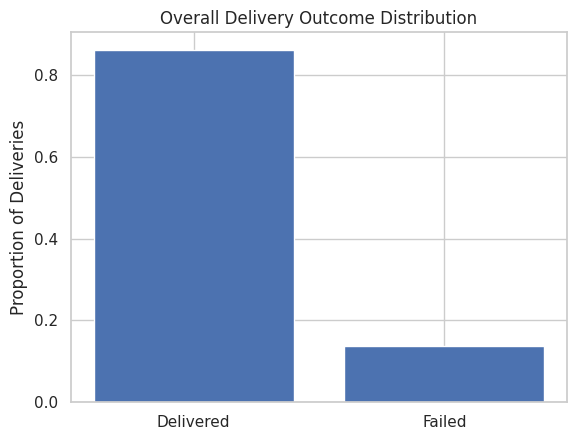

In [19]:
failure_rate = lagos_delivery['failed_delivery'].mean()

plt.bar(['Delivered', 'Failed'],
        [1 - failure_rate, failure_rate])
plt.ylabel('Proportion of Deliveries')
plt.title('Overall Delivery Outcome Distribution')
plt.show()

I checked the failure rate to see how common failed is in the overall delivery status. While there are more sucessful delivery status (delivered). The failed deliveries also represent operational risks.

Bivariate Analysis

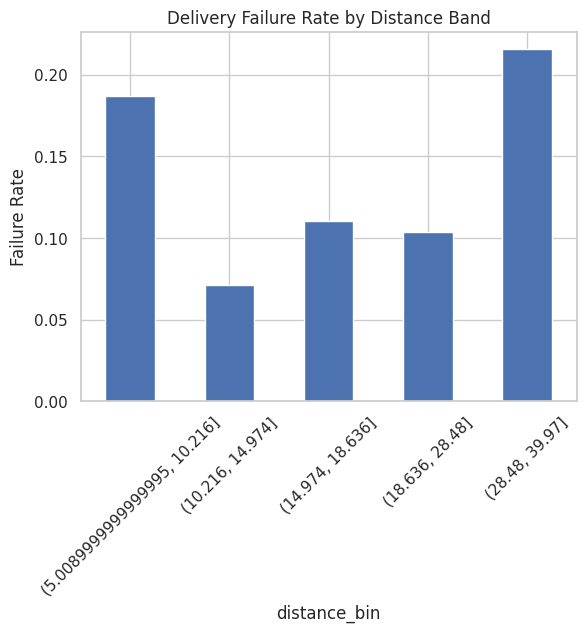

In [20]:
#Distance vs Failure Rate
lagos_delivery['distance_bin'] = pd.qcut(lagos_delivery['distance_km'],  5)
failure_by_distance = lagos_delivery.groupby('distance_bin')['failed_delivery'].mean()

failure_by_distance.plot(kind='bar')
plt.ylabel('Failure Rate')
plt.title('Delivery Failure Rate by Distance Band')
plt.xticks(rotation=45)
plt.show()

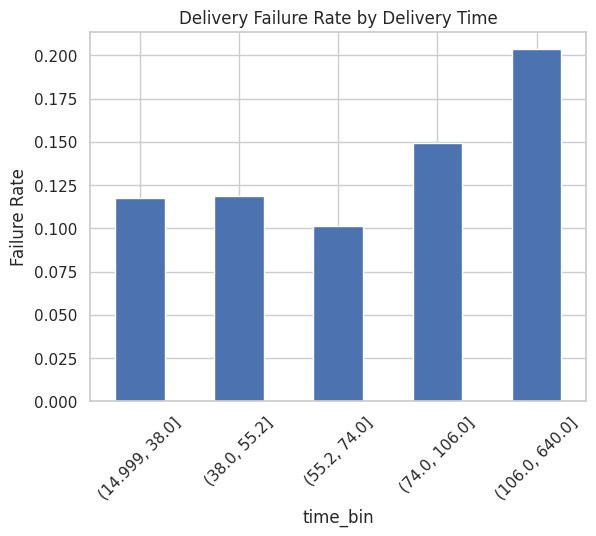

In [21]:
#Delivery Time vs Failure Rate
lagos_delivery['time_bin'] = pd.qcut(lagos_delivery['delivery_time_minutes'], 5)

failure_by_time = lagos_delivery.groupby('time_bin')['failed_delivery'].mean()

failure_by_time.plot(kind='bar')
plt.ylabel('Failure Rate')
plt.title('Delivery Failure Rate by Delivery Time')
plt.xticks(rotation=45)
plt.show()


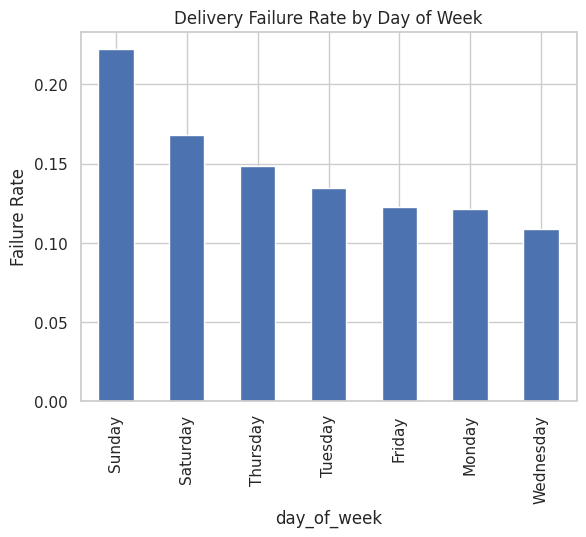

In [22]:
#Day of Week vs Failure Rate
failure_by_day = (
    lagos_delivery.groupby('day_of_week')['failed_delivery']
      .mean()
      .sort_values(ascending=False)
)

failure_by_day.plot(kind='bar')
plt.ylabel('Failure Rate')
plt.title('Delivery Failure Rate by Day of Week')
plt.show()


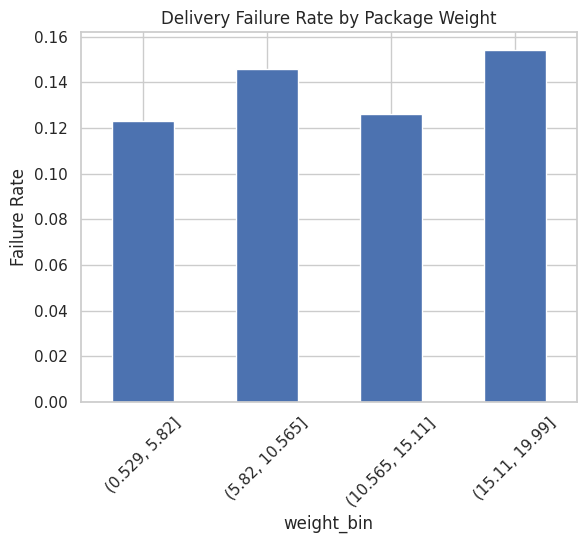

In [23]:
#Package Weight vs Failure Rate
lagos_delivery['weight_bin'] = pd.qcut(lagos_delivery['package_weight_kg'], 4)

failure_by_weight = lagos_delivery.groupby('weight_bin')['failed_delivery'].mean()

failure_by_weight.plot(kind='bar')
plt.ylabel('Failure Rate')
plt.title('Delivery Failure Rate by Package Weight')
plt.xticks(rotation=45)
plt.show()


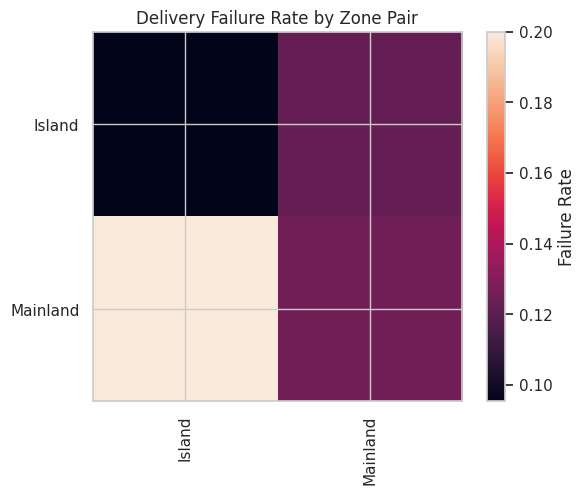

In [24]:
zone_matrix = (
    lagos_delivery.pivot_table(
        values='failed_delivery',
        index='pickup_zone',
        columns='delivery_zone',
        aggfunc='mean'
    )
)

plt.imshow(zone_matrix)
plt.colorbar(label='Failure Rate')
plt.xticks(range(len(zone_matrix.columns)), zone_matrix.columns, rotation=90)
plt.yticks(range(len(zone_matrix.index)), zone_matrix.index)
plt.title('Delivery Failure Rate by Zone Pair')
plt.show()


Multivariate Analysis

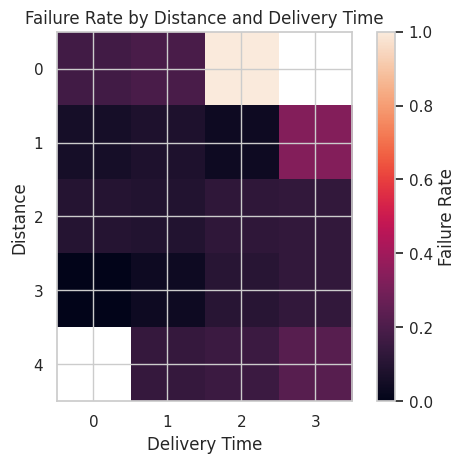

In [25]:
#Distance AND Delivery Time
lagos_delivery['time_bin'] = pd.qcut(lagos_delivery['delivery_time_minutes'], 4)

multi_dist_time = (
    lagos_delivery.groupby(['distance_bin', 'time_bin'])['failed_delivery']
      .mean()
      .unstack()
)

multi_dist_time

plt.imshow(multi_dist_time)
plt.colorbar(label='Failure Rate')
plt.xlabel('Delivery Time')
plt.ylabel('Distance')
plt.title('Failure Rate by Distance and Delivery Time')
plt.show()



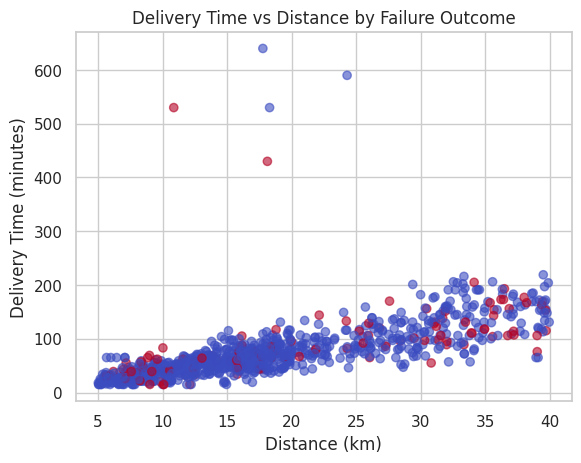

In [26]:
plt.scatter(
    lagos_delivery['distance_km'],
    lagos_delivery['delivery_time_minutes'],
    c=lagos_delivery['failed_delivery'],
    cmap='coolwarm',
    alpha=0.6
)
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (minutes)')
plt.title('Delivery Time vs Distance by Failure Outcome')
plt.show()


#Which routes/zones are most profitable vs most costly?

In [27]:
print(lagos_delivery.info())

<class 'pandas.core.frame.DataFrame'>
Index: 909 entries, 0 to 912
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   delivery_id            909 non-null    object        
 1   order_date             909 non-null    datetime64[ns]
 2   delivery_date          909 non-null    datetime64[ns]
 3   pickup_location        909 non-null    object        
 4   pickup_zone            909 non-null    object        
 5   delivery_location      909 non-null    object        
 6   delivery_zone          909 non-null    object        
 7   distance_km            909 non-null    float64       
 8   delivery_time_minutes  909 non-null    float64       
 9   time_slot              909 non-null    object        
 10  day_of_week            909 non-null    object        
 11  delivery_status        909 non-null    object        
 12  delivery_cost_ngn      909 non-null    float64       
 13  package_we

In [28]:
#Define the route
lagos_delivery['route'] = lagos_delivery['pickup_zone'] + ' → ' + lagos_delivery['delivery_zone']
lagos_delivery.head(5)

,delivery_id,order_date,delivery_date,pickup_location,pickup_zone,delivery_location,delivery_zone,distance_km,delivery_time_minutes,time_slot,...,traffic_level,is_weekend,cost_per_km,is_morning,is_evening,failed_delivery,distance_bin,time_bin,weight_bin,route
0,DEL00001,2024-11-21,2024-11-21,Ikeja,Mainland,Apapa,Mainland,9.13,46.0,Morning (7-11am),...,9,0,248.221249,1,0,1,"(5.0089999999999995, 10.216]","(43.0, 65.0]","(10.565, 15.11]",Mainland → Mainland
1,DEL00002,2024-11-15,2024-11-18,Ikeja,Mainland,Ikeja,Mainland,6.41,27.0,Morning (7-11am),...,7,0,293.687988,1,0,1,"(5.0089999999999995, 10.216]","(14.999, 43.0]","(10.565, 15.11]",Mainland → Mainland
2,DEL00003,2024-11-09,2024-11-12,Ajah,Island,Maryland,Mainland,29.73,121.0,Evening (3-7pm),...,7,0,146.694921,0,1,0,"(28.48, 39.97]","(96.0, 640.0]","(5.82, 10.565]",Island → Mainland
3,DEL00004,2024-09-20,2024-09-21,Mushin,Mainland,Yaba,Mainland,6.53,26.0,Afternoon (11am-3pm),...,8,1,178.401225,0,0,0,"(5.0089999999999995, 10.216]","(14.999, 43.0]","(15.11, 19.99]",Mainland → Mainland
4,DEL00005,2024-11-08,2024-11-08,Epe,Mainland,Ikoyi,Island,16.97,59.0,Morning (7-11am),...,6,0,174.390689,1,0,0,"(14.974, 18.636]","(43.0, 65.0]","(10.565, 15.11]",Mainland → Island


In [29]:
#Create a Route-level cost & efficiency summary
route_summary = (
    lagos_delivery.groupby('route')
      .agg(
          avg_cost_ngn=('delivery_cost_ngn', 'mean'),
          avg_cost_per_km=('cost_per_km', 'mean'),
          avg_distance=('distance_km', 'mean'),
          avg_time=('delivery_time_minutes', 'mean'),
          failure_rate=('failed_delivery', 'mean'),
          avg_rating=('customer_rating', 'mean'),
          volume=('delivery_id', 'count')
      )
      .reset_index()
)
print(route_summary)

                 route  avg_cost_ngn  avg_cost_per_km  avg_distance  \
0      Island → Island   2364.065238       197.615341     12.516310   
1    Island → Mainland   4289.514309       159.800914     27.162819   
2    Mainland → Island   4527.852432       161.552887     28.331081   
3  Mainland → Mainland   1853.639248       155.765365     12.535332   

     avg_time  failure_rate  avg_rating  volume  
0   60.619048      0.095238    3.916667      84  
1  102.058511      0.122340    3.420213     188  
2  116.113514      0.200000    3.432432     185  
3   52.002212      0.126106    3.924779     452  


In [30]:
#Highest average delivery cost
route_summary.sort_values(
    'avg_cost_ngn', ascending=False
).head(10)


,route,avg_cost_ngn,avg_cost_per_km,avg_distance,avg_time,failure_rate,avg_rating,volume
2,Mainland → Island,4527.852432,161.552887,28.331081,116.113514,0.200000,3.432432,185
1,Island → Mainland,4289.514309,159.800914,27.162819,102.058511,0.122340,3.420213,188
0,Island → Island,2364.065238,197.615341,12.516310,60.619048,0.095238,3.916667,84
3,Mainland → Mainland,1853.639248,155.765365,12.535332,52.002212,0.126106,3.924779,452


The table above shows the highest average delivery cost analysis for each route. Route-level analysis shows that Mainland → Island deliveries are the most costly and least reliable, driven by long distances and extended delivery times. In contrast, Mainland → Mainland routes are the most cost-efficient, fastest, and highest-volume, making them the most profitable operational segment. Island → Island routes demonstrate strong reliability and customer satisfaction but remain underutilized, indicating potential for profitable expansion. These findings highlight clear opportunities for route optimization, pricing differentiation, and targeted capacity allocation.

In [31]:
#Identify cost efficient routes
profitable_routes = route_summary[
    (route_summary['failure_rate'] < route_summary['failure_rate'].median()) |
    (route_summary['avg_cost_per_km'] < route_summary['avg_cost_per_km'].median())
].sort_values(
    ['volume', 'avg_rating'], ascending=[False, False]
)

profitable_routes.head(10)


,route,avg_cost_ngn,avg_cost_per_km,avg_distance,avg_time,failure_rate,avg_rating,volume
3,Mainland → Mainland,1853.639248,155.765365,12.535332,52.002212,0.126106,3.924779,452
1,Island → Mainland,4289.514309,159.800914,27.162819,102.058511,0.122340,3.420213,188
0,Island → Island,2364.065238,197.615341,12.516310,60.619048,0.095238,3.916667,84


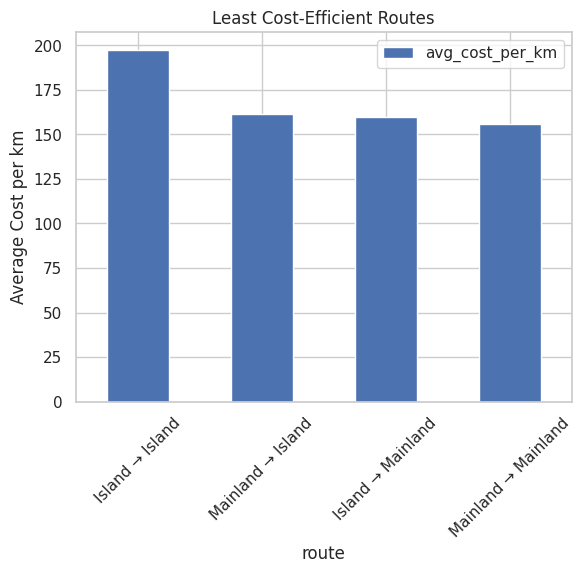

In [32]:
#Visualizing Cost per km by Route
route_summary.sort_values(
    'avg_cost_per_km', ascending=False
).head(10).plot(
    x='route', y='avg_cost_per_km', kind='bar'
)

plt.ylabel('Average Cost per km')
plt.title('Least Cost-Efficient Routes')
plt.xticks(rotation=45)
plt.show()


These are some of the findings from the results above:

1.  Mainland → Mainland routes are the most cost-efficient and operationally
strong. These routes record the lowest average cost per kilometre (₦155.8/km), the shortest delivery times, high customer satisfaction, and the highest delivery volume. This combination indicates strong economies of scale and efficient operations.

2.  Island → Island routes are the least cost-efficient.
Despite short delivery distances and the lowest failure rate, Island → Island routes have the highest cost per kilometre (₦197.6/km). This suggests higher fixed or environmental costs, likely driven by congestion, limited routing options, or operational constraints within island zones.

3.  Inter-zone routes (Island ↔ Mainland) are structurally expensive.
These routes show moderate cost per kilometre but significantly higher delivery distances and times, alongside lower customer ratings. Their cost structure appears driven by geographic and traffic-related challenges rather than inefficiencies alone.

# **Recommendations**

* Mainland → Mainland routes should be prioritized for capacity expansion, service guarantees, and promotional strategies due to their strong cost efficiency and reliability.

* Island → Island routes require pricing review or targeted operational improvements to address high per-kilometre costs.

* Island ↔ Mainland routes should focus on traffic-aware scheduling, route optimisation, or differentiated pricing to mitigate structural cost pressures.

#How can we reduce average delivery time

In [33]:
#Average Delivery Time
print(round(lagos_delivery['delivery_time_minutes'].mean(), 0))

76.0


The Average delivery time for all routes whether Island - Island, Island - Mainland, Mainland - Mainland and Mainland - Island is 76 minutes.

Some key drivers affecting delivery time

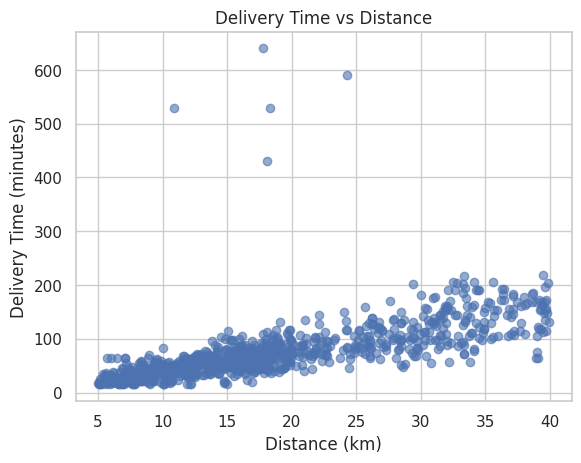

In [34]:
#Distance
plt.scatter(
    lagos_delivery['distance_km'],
    lagos_delivery['delivery_time_minutes'],
    alpha=0.6
)
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (minutes)')
plt.title('Delivery Time vs Distance')
plt.show()


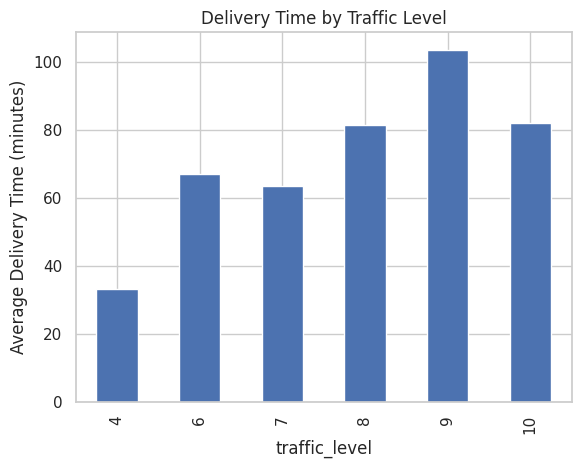

In [35]:
#Traffic Level
traffic_time = lagos_delivery.groupby('traffic_level')['delivery_time_minutes'].mean()

traffic_time.plot(kind='bar')
plt.ylabel('Average Delivery Time (minutes)')
plt.title('Delivery Time by Traffic Level')
plt.show()


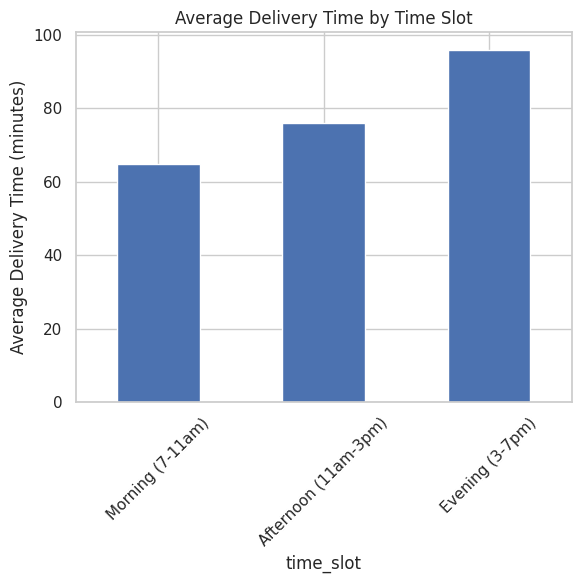

In [36]:
#Time Slot
slot_time = lagos_delivery.groupby('time_slot')['delivery_time_minutes'].mean().sort_values()

slot_time.plot(kind='bar')
plt.ylabel('Average Delivery Time (minutes)')
plt.title('Average Delivery Time by Time Slot')
plt.xticks(rotation=45)
plt.show()


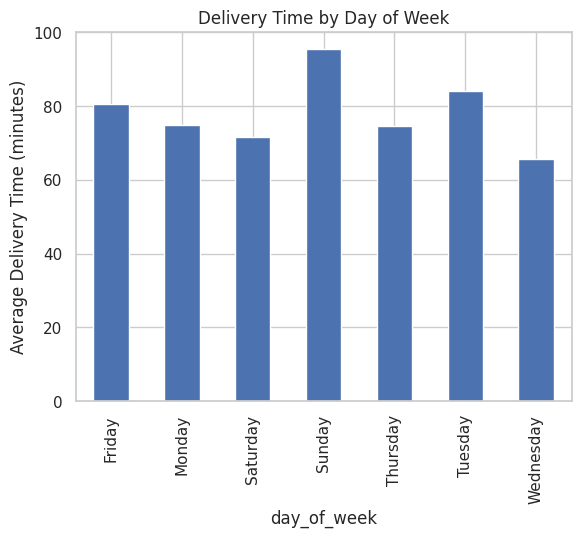

In [37]:
#Day of the week
day_time = lagos_delivery.groupby('day_of_week')['delivery_time_minutes'].mean()

day_time.plot(kind='bar')
plt.ylabel('Average Delivery Time (minutes)')
plt.title('Delivery Time by Day of Week')
plt.show()


In [38]:
#Average delivery time on weekends
lagos_delivery.groupby('is_weekend')['delivery_time_minutes'].mean()

,delivery_time_minutes
is_weekend,
0,75.885832
1,77.450549


After establishing the average delivery time across all routes, I examined the factors that affect it to identify effective strategies for reducing it. My analysis revealed that delivery time is influenced by distance, traffic conditions, and delivery scheduling (time_slot). Specifically, long-distance deliveries during high-traffic periods and on weekends contribute disproportionately to delays. Additionally, a small number of zone pairs consistently exhibit extended delivery times, highlighting structural inefficiencies in the route.

To address these issues, the following should be considered:
*   Reallocating long-distance deliveries to low-traffic time slots
*   Increasing capacity during peak periods would significantly reduce the overall average delivery time.


*   Schedule more deliveries on weekdays and fewer on weekends to improve delivery time.
*   Deliveries in the Morning time slot should be used more, with a few considerations for the afternoon time slot.







#How does traffic level correlate with delivery performance?

In [39]:
#Traffic Distribution
lagos_delivery['traffic_level'].value_counts().sort_index()


,count
traffic_level,
4,46
6,200
7,224
8,185
9,194
10,60


In [40]:
#Traffic level vs Delivery Time
lagos_delivery.groupby('traffic_level')['delivery_time_minutes'].mean()


,delivery_time_minutes
traffic_level,
4,33.282609
6,67.170000
7,63.491071
8,81.351351
9,103.618557
10,82.100000


<Axes: xlabel='traffic_level'>

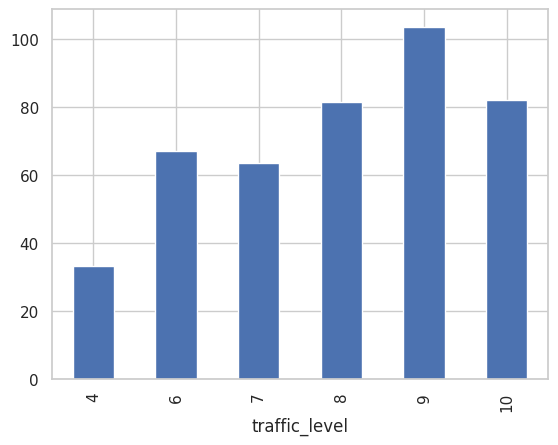

In [41]:
#Visualize Traffic Level vs Delivery Time
lagos_delivery.groupby('traffic_level')['delivery_time_minutes'].mean().plot(kind='bar')


In [42]:
#Traffic level vs Failure Rate
lagos_delivery.groupby('traffic_level')['failed_delivery'].mean()


,failed_delivery
traffic_level,
4,0.217391
6,0.155000
7,0.116071
8,0.118919
9,0.154639
10,0.100000


<Axes: xlabel='traffic_level'>

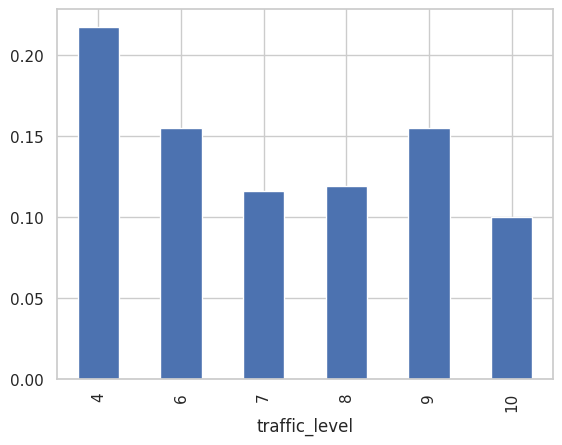

In [43]:
#Visualize Traffic level vs Failure Rate
lagos_delivery.groupby('traffic_level')['failed_delivery'].mean().plot(kind='bar')


In [44]:
#Traffic level vs Cost
lagos_delivery.groupby('traffic_level')[['delivery_cost_ngn', 'cost_per_km']].mean()


,delivery_cost_ngn,cost_per_km
traffic_level,,
4,2546.576522,160.094743
6,3076.543250,163.406089
7,2559.266741,157.155547
8,2968.274595,157.542927
9,3513.846598,169.811946
10,2399.397500,159.968535


<Axes: xlabel='traffic_level'>

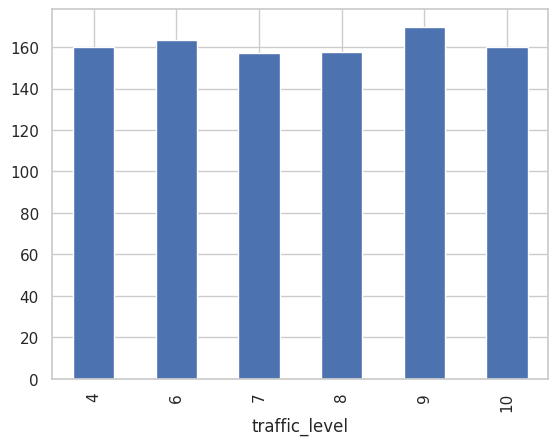

In [45]:
#Visualize Traffic Level vs Cost
lagos_delivery.groupby('traffic_level')['cost_per_km'].mean().plot(kind='bar')


In [46]:
#Traffic level vs Customer Rating
lagos_delivery.groupby('traffic_level')['customer_rating'].mean()


,customer_rating
traffic_level,
4,4.065217
6,3.900000
7,3.723214
8,3.697297
9,3.500000
10,3.616667


<Axes: xlabel='traffic_level'>

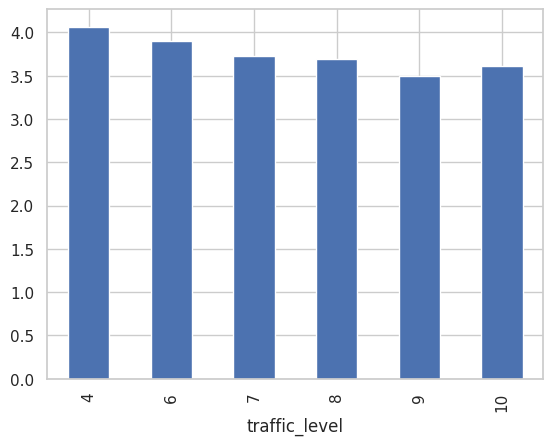

In [47]:
#Visualizing Traffic level vs Customer Rating
lagos_delivery.groupby('traffic_level')['customer_rating'].mean().plot(kind='bar')


Correlation analysis

In [48]:
#Correlation analysis
lagos_delivery[['traffic_level',
    'delivery_time_minutes',
    'failed_delivery',
    'cost_per_km',
    'customer_rating']].corr()


,traffic_level,delivery_time_minutes,failed_delivery,cost_per_km,customer_rating
traffic_level,1.000000,0.279350,-0.039656,0.038804,-0.170271
delivery_time_minutes,0.279350,1.000000,0.086773,-0.125875,-0.292605
failed_delivery,-0.039656,0.086773,1.000000,0.433598,0.131710
cost_per_km,0.038804,-0.125875,0.433598,1.000000,0.178583
customer_rating,-0.170271,-0.292605,0.131710,0.178583,1.000000


Multivariate Analysis

In [49]:
#Traffic and Distance effect on Delivery Time
pd.pivot_table(
    lagos_delivery,
    values='delivery_time_minutes',
    index='traffic_level',
    columns='distance_bin',
    aggfunc='mean'
)


distance_bin,"(5.0089999999999995, 10.216]","(10.216, 14.974]","(14.974, 18.636]","(18.636, 28.48]","(28.48, 39.97]"
traffic_level,,,,,
4,21.166667,24.230769,39.545455,45.500000,57.500000
6,26.060606,38.027778,85.272727,71.266667,101.095238
7,30.800000,49.500000,63.463415,92.641026,112.031250
8,32.088235,54.450000,68.583333,96.750000,149.461538
9,46.555556,77.461538,77.363636,101.826923,160.410714
10,40.437500,70.800000,81.812500,113.714286,185.333333


In [50]:
pd.pivot_table(
    lagos_delivery,
    values='failed_delivery',
    index='traffic_level',
    columns='pickup_zone',
    aggfunc='mean'
)


pickup_zone,Island,Mainland
traffic_level,,
4,0.200000,0.222222
6,0.086207,0.183099
7,0.058824,0.141026
8,0.160714,0.100775
9,0.138462,0.162791
10,0.133333,0.088889


Save Final Cleaned Data

In [51]:
lagos_delivery.info()
lagos_delivery.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 909 entries, 0 to 912
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   delivery_id            909 non-null    object        
 1   order_date             909 non-null    datetime64[ns]
 2   delivery_date          909 non-null    datetime64[ns]
 3   pickup_location        909 non-null    object        
 4   pickup_zone            909 non-null    object        
 5   delivery_location      909 non-null    object        
 6   delivery_zone          909 non-null    object        
 7   distance_km            909 non-null    float64       
 8   delivery_time_minutes  909 non-null    float64       
 9   time_slot              909 non-null    object        
 10  day_of_week            909 non-null    object        
 11  delivery_status        909 non-null    object        
 12  delivery_cost_ngn      909 non-null    float64       
 13  package_we

,0
delivery_id,0
order_date,0
delivery_date,0
pickup_location,0
pickup_zone,0
delivery_location,0
delivery_zone,0
distance_km,0
delivery_time_minutes,0
time_slot,0


In [52]:
lagos_delivery.to_csv('lagos_delivery_cleaned.csv', index=False)
from google.colab import files
files.download('lagos_delivery_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>